# Transfer matrix method for effective spin-foam cosmology

## Definitions and setup

In [109]:
using Pkg
Pkg.activate("/Users/jercheal/.julia/environments/v1.11/transfer_matrix/")
using Plots
using NLsolve
using BenchmarkTools

using LaTeXStrings
plot_font = "Computer Modern"
default(fontfamily=plot_font,
        linewidth=2, framestyle=:box, label=nothing, grid=false)
#scalefontsizes(1.2)

include("wynn.jl")

  Activating project at `~/.julia/environments/v1.11/transfer_matrix`


wynn (generic function with 1 method)

In [307]:
function height(j0::Float64, j1::Float64, k::Float64)
    res_squared = ((j0 - j1)^2 + 8*k^2)/(2 * (sqrt(j0) + sqrt(j1))^2)
    res = sqrt(complex(res_squared))
    return real(res)
end

function four_volume(j0::Float64, j1::Float64, k::Float64)
    res_squared = (j0 + j1)^2/32 * ((j0 - j1)^2 + 8*k^2)
    res = sqrt(complex(res_squared))
    return real(res)
end

function S_III(j0::Float64, j1::Float64, k::Float64, Λ::Float64) 
    res = 6 * (j0 - j1) * asinh((j1 - j0) / (sqrt(complex(16*k^2 + (j1 - j0)^2)))) + 12 * k * (pi/2 - acos((j0 - j1)^2 / (16*k^2 + (j0 - j1)^2))) - Λ * four_volume(j0, j1, k)
    return real(res)
end

function dS_IIIdk(j0::Float64, j1::Float64, k::Float64, Λ::Float64)
    res = 12 * (pi/2 - acos((j0 - j1)^2 / (16*k^2 + (j0 - j1)^2))) - Λ * ((j0 + j1)^2 * k) / (4 * four_volume(j0, j1, k))
    return res
end

function μ_ESF(j0::Float64, j1::Float64, k::Float64)
    res = 4/sqrt(2) * (height(j0, j1, k) * (sqrt(j0) + sqrt(j1)))^(-3/2) * k
    return real(res)
end

function construct_matrix(jmax::Int64, γ::Float64, Λ::Float64, rtol::Float64)
    N = 2 * jmax
    mat = zeros(ComplexF64, N, N)
    for j0 in 1:N
        for j1 in 1:j0
            kmax = (10 * abs(j0 - j1) + 50)
            kvals = 0.5:0.5:kmax
            amplitudes = [μ_ESF(γ * 0.5 * j0, γ * 0.5 * j1, k) *  exp(im * S_III(γ * 0.5 * j0, γ * 0.5 * j1, k, Λ)) for k in kvals]
            mat_element = wynn(accumulate(+, amplitudes)[2 * kmax - 50:2 * kmax], rtol)[1]
            mat[j0, j1] = mat_element
            mat[j1, j0] = mat_element
        end
    end
    return mat
end

construct_matrix (generic function with 2 methods)

## Finding classical solutions with NLsolve

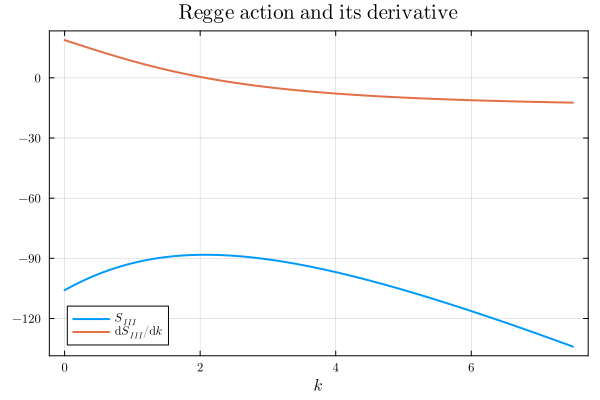

In [3]:
ks = range(0, 7.5, 1000)
S_vals = [S_III(10.0, 20.0, k, 1.0) for k in ks]
dS_vals = [dS_IIIdk(10.0, 20.0, k, 1.0) for k in ks]
plot(ks, S_vals, label=L"S_{III}")
plot!(ks, dS_vals, label=L"\mathrm{d}S_{III}/\mathrm{d}k", xlabel=L"k", title=L"\textrm{Regge~action~and~its~derivative}", grid=true)

For this type of boundary data, we observe that the classical solution should be around k = 2. Let's see if we can reproduce this with the NLsolve package of Julia.

In [4]:
function S_III_fxdbdry(k::Vector{Float64})
    j0 = 10.0
    j1 = 20.0
    Λ = 1.0
    return S_III(j0, j1, k[1], Λ)
end

function dS_III_fxbdry(k::Vector{Float64})
    j0 = 10.0
    j1 = 20.0
    Λ = 1.0
    return dS_IIIdk(j0, j1, k[1], Λ)    
end

sol = nlsolve(S_III_fxdbdry, dS_III_fxbdry, [2.0], iterations=1000, xtol=1e-6, ftol=1e-6)
println("k_sol = ", sol.zero[1])



k_sol = 2.07686179492998


Solving a single Regge equations works straightforwardly with the NLsolve package. It will be important later to see whether this works for multiple variables...

## Establishing the convergence acceleration for partition function and expectation values

Let's choose boundary data $j_0 = 10.0$, $j_1 = 20.0$ and $\Lambda = 1.0$ and look at the partition function and the expectation value of $k$. 

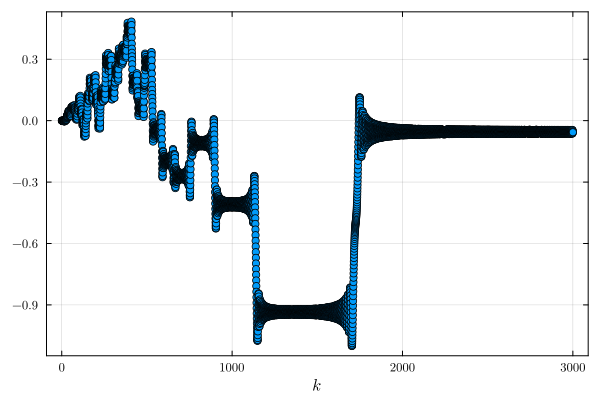

In [338]:
j0 = 1.0
j1 = 1000.0
Λ = 1.0
ks = 0.5:0.5:3000.0
integrands = [ μ_ESF(j0, j1, k) * exp(im * S_III(j0, j1, k, Λ)) for k in ks]
integrands_k = [k * μ_ESF(j0, j1, k) * exp(im * S_III(j0, j1, k, Λ)) for k in ks]
part_sums = accumulate(+, integrands)
part_sums_k = accumulate(+, integrands_k)
scatter(ks, real(part_sums), grid=true, xlabel=L"k")
#scatter(ks, real(part_sums_k), grid=true, xlabel=L"k")

In [326]:
transf_mat[26,26]

1.7421361679308038 - 3.7427785845371866im

Wynn's algorithm has been fixed now with a convergence condition. Divergences can be avoided in this way.

In [298]:
wynn(part_sums[500:550], 1e-20)[1]

2.7176627886752933 + 1.2951770132783471im

In [347]:
@btime transf_mat = construct_matrix(50, 1.0, 1.0, 1e-20)

  680.021 ms (64244 allocations: 328.04 MiB)


100×100 Matrix{ComplexF64}:
   1.48078-3.47138im   0.0757971-3.19302im   …   -5.70468-8.473im
 0.0757971-3.19302im    0.445897-2.35938im        -5.1998+1.33215im
  -2.43926-2.02329im    -0.56936-2.201im         -1.60195+3.46205im
  -2.56402+1.71668im    -2.33479-0.667857im       2.71766+1.29518im
   1.38103+2.36594im    -1.01872+2.30501im       -2.31433+2.42135im
     1.915-1.20616im     2.24699+0.736326im  …    2.45381-0.657324im
  -1.17274-1.59566im     0.20996-1.99818im       0.851997-1.8165im
  -1.27996+1.54473im    -1.69085+0.215567im       1.77524-0.466495im
   2.03965+0.360163im   0.732014+1.50553im      -0.675765+2.48285im
  -1.00495-1.67461im    0.908882-1.54007im       -1.42105-2.2179im
          ⋮                                  ⋱  
 -0.693682+0.69384im   -0.491661+0.725435im     -0.190312+1.74978im
 -0.107421-0.859417im  -0.292969-0.93016im       0.398314+0.630751im
  0.668929+0.347835im    1.01679+0.264376im      0.558731-0.180732im
 -0.562617+0.335096im  -0.718218+0.8297

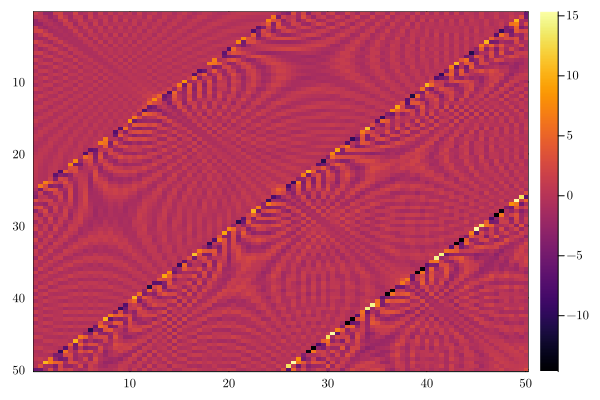

In [349]:
heatmap(0.5:0.5:50, 0.5:0.5:50, real(transpose(transf_mat)), yflip=true)

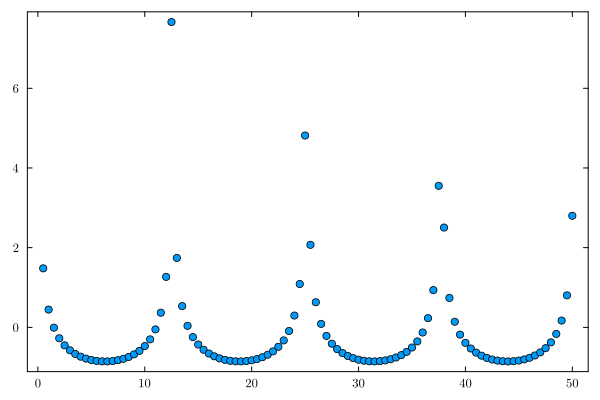

In [346]:
scatter(0.5:0.5:50, real([transf_mat[n, n] for n in 1:100]))